In [19]:
'''
Vi importerer nødvendige biblioteker
og definerer globale variabler med stinavne/filnavne 
'''
from PIL import Image, ImageDraw
import csv
import os
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torch
from cv2 import cv2
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchvision import models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from numpy import argmax
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from skimage import transform


csvpath = 'classifier/license_plates_detection_train.csv'
imagespath = 'classifier/images'


In [20]:
'''
Data preparation

Vi forbereder vores datasets 

'''
class LicensePlatesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = plt.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks[1], landmarks[0], landmarks[3], landmarks[2]])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        sample = {'image': image, 'bb': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [21]:
'''
Vi laver custom transforms
'''

class Rescale(object):
    """
    Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bb = sample['image'], sample['bb']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        # trans = transforms.Resize((new_h, new_w))
        # img = trans(image)
        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for bounding boxes because for images,
        # x and y axes are axis 1 and 0 respectively
        bb = bb * [new_w / w, new_h / h]
        return {'image': img, 'bb': bb}

class ToTensor(object):
   def __call__(self, sample):
       img, bb = sample['image'], sample['bb']
       img = img.transpose(2,0,1)
       return torch.from_numpy(img).float(), torch.from_numpy(bb).float()

In [22]:
trans = transforms.Compose([
    Rescale((100, 100)),
    ToTensor(),
])

In [23]:
lpDataset = LicensePlatesDataset(csvpath, imagespath, transform=trans)

dataloader = DataLoader(lpDataset, batch_size=16, shuffle=True)

In [24]:
def create_mask(bb, x):
    rows, cols, *_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int64)
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1
    return Y


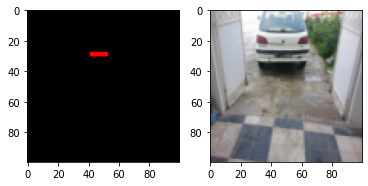

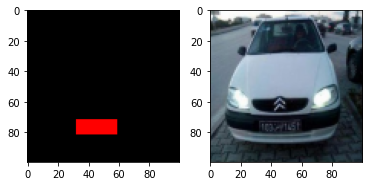

In [25]:
dict_load = next(iter(dataloader))

lm_ar = dict_load[0]
x_ar = dict_load[1]

imgCount = 2

for idx in range(imgCount):
    bb_in = x_ar[idx].flatten().numpy()
    img_in = lm_ar[idx].squeeze().permute(1,2,0)

    mask = create_mask(np.array([bb_in[0], bb_in[1], bb_in[2], bb_in[3]]), img_in)
    mask.resize(3, 100, 100)
    mask = torch.from_numpy(mask).squeeze().permute(1,2,0)

    ar = [mask, img_in]
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(ar[i])

    plt.show()
    plt.close()

In [26]:
'''
Choose model

Vi klargører vore model
Her bruger vi pre-trained ResNet34 deep learning model fra PyTorch models
'''
# Neural Nets
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # resnet = models.resnet50(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        # self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.bb(x)
        # return self.classifier(x), self.bb(x)

In [27]:
'''
Tuning
'''
model = BB_model()

running_loss = 0.0
running_corrects = 0
n_epochs = 30
total_loss = 0
total_correct = 0
optimizer = optim.Adam(model.parameters(), lr=0.001) 
'''
Training
'''
for epoch in range(n_epochs):
    model.train()

    for images, labels in dataloader:
       
        preds = model(images)
        
        loss = F.l1_loss(preds, labels.reshape(-1, 4), reduction="sum")
        total_loss+= loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch +1, float(loss)))

print('Finished Training')

Epoch: 1, Loss: 870.312134
Epoch: 2, Loss: 583.896423
Epoch: 3, Loss: 562.021851
Epoch: 4, Loss: 211.061890
Epoch: 5, Loss: 176.558777
Epoch: 6, Loss: 224.831863
Epoch: 7, Loss: 88.619766
Epoch: 8, Loss: 124.598114
Epoch: 9, Loss: 180.155548
Epoch: 10, Loss: 201.753342
Epoch: 11, Loss: 79.559196
Epoch: 12, Loss: 162.667999
Epoch: 13, Loss: 192.021637
Epoch: 14, Loss: 74.863419
Epoch: 15, Loss: 90.074829
Epoch: 16, Loss: 199.757431
Epoch: 17, Loss: 134.174149
Epoch: 18, Loss: 152.280640
Epoch: 19, Loss: 147.176147
Epoch: 20, Loss: 133.517197
Epoch: 21, Loss: 120.478157
Epoch: 22, Loss: 142.639862
Epoch: 23, Loss: 128.919556
Epoch: 24, Loss: 88.289536
Epoch: 25, Loss: 77.609032
Epoch: 26, Loss: 111.528946
Epoch: 27, Loss: 106.535767
Epoch: 28, Loss: 173.263458
Epoch: 29, Loss: 50.481457
Epoch: 30, Loss: 85.179153
Finished Training


In [28]:
torch.save(model, "outputs/model.pt")

In [29]:
'''
Tilføjer bouding box til billedet
'''
def show_corner_bb(im, bb, color='red'):
    plt.imshow(im)
    rectangle_rect = plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color, fill=False, lw=3)
    plt.gca().add_patch(rectangle_rect)


tensor([[21.5634, 46.8861, 50.4077, 57.4558],
        [35.4827, 57.1984, 66.0280, 63.9157]], grad_fn=<SliceBackward0>)
tensor([[19.2182, 45.6566, 48.8599, 51.5152],
        [31.7848, 59.2322, 61.8582, 64.3510]])


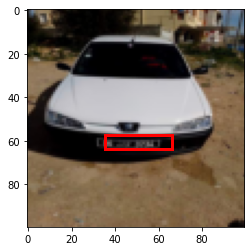

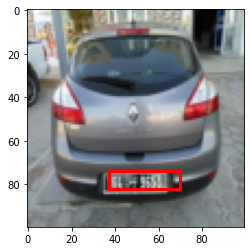

In [30]:
'''
Prediction
'''
dict_load = next(iter(dataloader))

lm_ar = dict_load[0]
x_ar = dict_load[1]

preds = model(lm_ar)
print(preds[:2])

print(x_ar.reshape(-1,4)[:2])

imgCount = 2

for idx in range(imgCount):
    bb_in = preds[idx+1].flatten().detach().numpy()
    img_in = lm_ar[idx+1].squeeze().permute(1,2,0)

    mask = show_corner_bb(img_in, np.array([bb_in[0], bb_in[1], bb_in[2], bb_in[3]]))
  
    plt.show()
    plt.close()